# Lab Exercise 1: Advanced Python with Pandas and NumPy

In [18]:
# Importing all the necessary modules
import pandas as pd
import mysql.connector
from mysql.connector import Error
import mydb_config
import numpy as np
import matplotlib.pyplot as plt


In [19]:
# Fetching the dataset

orders_path = ('./ShopEase Data/Orders.csv')
products_path = ('./ShopEase Data/products.csv')

orders = pd.read_csv(orders_path)
products = pd.read_csv(products_path)

## The sales dataset should contain columns like
#### Order ID, Customer ID, Order Date, Product ID, Product Name, Category, Quantity Sold, Price and Total Price

In [20]:
# To obtain the Sales dataset, Merge dataset
sales = pd.merge(orders,products)

In [21]:
# Viewing the info of the dataset
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_id      570 non-null    int64  
 1   Cutomer_id    570 non-null    int64  
 2   order_date    570 non-null    object 
 3   product_id    570 non-null    int64  
 4   quantity      570 non-null    int64  
 5   product_name  570 non-null    object 
 6   category      570 non-null    object 
 7   price         570 non-null    float64
dtypes: float64(1), int64(4), object(3)
memory usage: 35.8+ KB


In [22]:
# Viewing the sales column
sales.columns

Index(['order_id', 'Cutomer_id', 'order_date', 'product_id', 'quantity',
       'product_name', 'category', 'price'],
      dtype='object')

In [23]:
# Updating some columns name for clarity
sales.rename(columns={'Cutomer_id':'Customer_id','price':'Unit Price'},inplace=True)

In [24]:
# Add a new column that contains the revenue
sales['Total revenue'] = np.multiply(sales['Unit Price'],sales['quantity'])

In [25]:
#Converting date date types
sales['date'] = pd.to_datetime(sales['order_date'])
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales['day'] = sales['date'].dt.day

In [26]:
# dropping the order_date and the date column
sales = sales.drop(columns=(['order_date','date']))

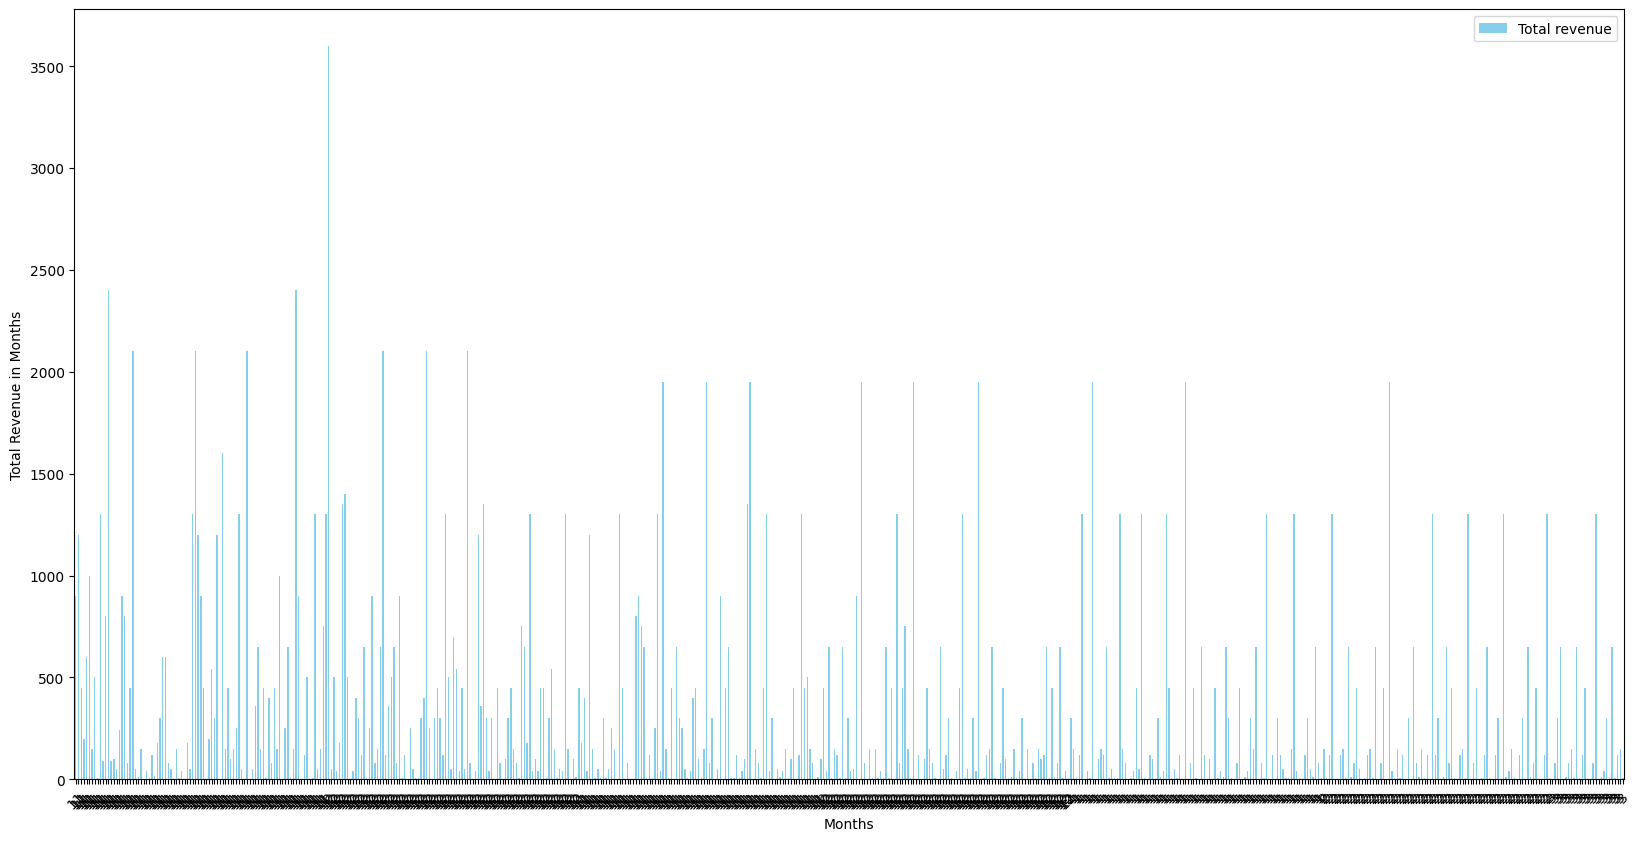

In [27]:
# Visualizing the monthly trends
# Visualization: Plot the monthly sales trend using Pandas’ plotting capabilities.
sales.plot(
    x= 'month',
    y= 'Total revenue',
    kind='bar',
    color='skyblue',
    xlabel='Months',
    ylabel='Total Revenue in Months',
    figsize=(20,10),
    )
plt.xticks(rotation=45) 
plt.show()


In [28]:
# Checking the data quality
def data_quality(data):
    print("\nData quality checks:")
    print("NaN values:\n", data.isnull().sum())
    print("Duplicate rows:", data.duplicated().sum())

In [29]:
# Making the database connections 
def connections_with_database(host,user,password,database):
    try:
        connection = mysql.connector.connect(
            host=host,
            user = user,
            password = password,
            database = database
        )
        if connection.is_connected():
            print('Connected to database')
            return connection
    except Error as e:
        print("Error connecting to the database:", e)
        return None

In [30]:
sales.head(5)

,order_id,Customer_id,product_id,quantity,product_name,category,Unit Price,Total revenue,year,month,day
0,1,20,3,2,Tablet,Electronics,450.0,900.0,2024,11,1
1,2,36,1,1,Laptop,Electronics,1200.0,1200.0,2024,11,1
2,3,1,8,3,Headphones,Electronics,150.0,450.0,2024,11,1
3,4,36,6,1,Smartwatch,Electronics,200.0,200.0,2024,11,2
4,5,14,12,2,Desk,Furniture,300.0,600.0,2024,11,2


In [33]:
# Inserting the sales data into the MySQL database
def insert_data_to_database(connection, data):
    insert_query = """
        INSERT INTO sales (order_id, Customer_id, product_id, quantity, product_name, category, Unit_Price, Total_revenue, year, month, day)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """
    cursor = connection.cursor()
    try:
        for _, row in data.iterrows():
            cursor.execute(insert_query, (
                row['order_id'], row['Customer_id'], row['product_id'], 
                row['quantity'], row['product_name'], 
                row['category'], row['Unit Price'], 
                row['Total revenue'], row['year'], 
                row['month'], row['day']
            ))
        connection.commit()
        print("Data inserted successfully.")
    except Error as e:
        print("Failed to insert data:", e)
        connection.rollback()
    finally:
        cursor.close()

In [34]:
def main():
    # Define URL and database parameters
    db_params = {
        "host": mydb_config.host(),
        "user": mydb_config.user(),
        "password": mydb_config.password(),
        "database": mydb_config.database()
    }



    # Prepare DataFrame
    data_quality(sales)

    # Database operations
    connection = connections_with_database(**db_params)
    if connection:
        insert_data_to_database(connection, sales)
        connection.close()
        print("Database connection closed.")

# if __name__ == "__main__":
main()


Data quality checks:
NaN values:
 order_id         0
Customer_id      0
product_id       0
quantity         0
product_name     0
category         0
Unit Price       0
Total revenue    0
year             0
month            0
day              0
dtype: int64
Duplicate rows: 0
Connected to database
Data inserted successfully.
Database connection closed.
